## Modeling

**Imports**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns

**Reading in Data**

In [2]:
model_sets = np.load('../data/model_sets.npy')
model_sets.shape

(36003, 21)

In [3]:
#remember, I am modeling for song n + 1 based on songs n previously played:
X_rr, y_rr = model_sets[:, :-1], model_sets[:, -1] 

In [4]:
X_rr.shape, y_rr.shape

((36003, 20), (36003,))

**Train-Test Split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_rr, y_rr, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [6]:
print(f'X_train and y_train: {X_train.shape}, {y_train.shape}')
print(f'X_test and y_test: {X_test.shape}, {y_test.shape}')

X_train and y_train: (28802, 20), (28802,)
X_test and y_test: (7201, 20), (7201,)


**Modeling - Third Attempt, with Regularization**

In [8]:
#https://www.tensorflow.org/text/tutorials/text_generation
songs = np.array(model_sets).tolist()
songs = [item for sublist in songs for item in sublist]

vocab = set(songs)
print(f'{len(vocab)} unique songs!')

970 unique songs!


In [9]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 970

# Number of RNN units
rnn_units = 516

In [10]:
#https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/
#train labels:
X_train_ohe = np.array([to_categorical(x, num_classes = vocab_size) for x in X_train])
y_train_ohe = to_categorical(y_train, num_classes = vocab_size)

#test labels:
X_test_ohe = np.array([to_categorical(x, num_classes = vocab_size) for x in X_test])
y_test_ohe = to_categorical(y_test, num_classes = vocab_size)

In [11]:
print(f'Train shape: {X_train_ohe.shape}, Test shape: {X_test_ohe.shape}')
print(f'Train shape: {y_train_ohe.shape}, Test shape: {y_test_ohe.shape}')

Train shape: (28802, 20, 970), Test shape: (7201, 20, 970)
Train shape: (28802, 970), Test shape: (7201, 970)


In [12]:
#https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
#https://www.tensorflow.org/text/tutorials/text_generation
#https://www.analyticsvidhya.com/blog/2021/08/predict-the-next-word-of-your-text-using-long-short-term-memory-lstm/
#https://stackoverflow.com/questions/55774632/gridsearchcv-randomizedsearchcv-with-lstm

model = Sequential()

#first layer, embedding:
model.add(Embedding(input_dim = vocab_size, output_dim = 100, input_length = X_train_ohe.shape[1]))

#second layer, LSTM:
model.add(LSTM(rnn_units))

#third layer, dropout:
model.add(Dropout(rate = 0.20))
          
#fourth layer, LSTM:
model.add(Dense(rnn_units/4, activation = 'relu'))

#final dense layer with softmax activation:
model.add(Dense(embedding_dim, activation ='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           97000     
                                                                 
 lstm (LSTM)                 (None, 516)               1273488   
                                                                 
 dropout (Dropout)           (None, 516)               0         
                                                                 
 dense (Dense)               (None, 129)               66693     
                                                                 
 dense_1 (Dense)             (None, 970)               126100    
                                                                 
Total params: 1,563,281
Trainable params: 1,563,281
Non-trainable params: 0
_________________________________________________________________


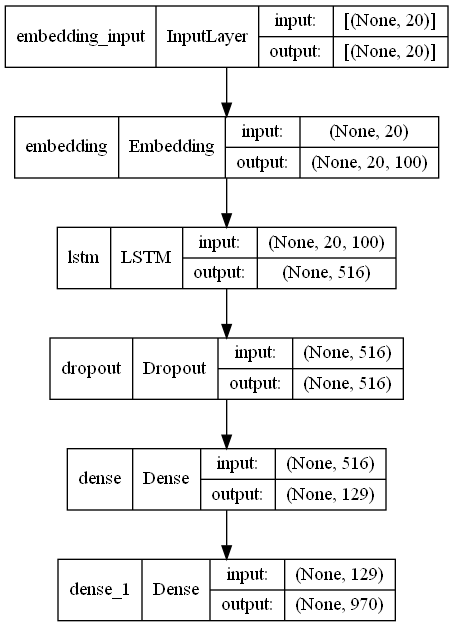

In [14]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
plot_model(model, to_file='model_plot_0.png', show_shapes=True, show_layer_names=True)

In [15]:
opt = Adam(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train_ohe,
                    validation_data = (X_test, y_test_ohe),
                    batch_size = 128, 
                    epochs = 20)

Epoch 1/20
226/226 [==============================] - 37s 158ms/step - loss: 5.3923 - accuracy: 0.0382 - val_loss: 5.0315 - val_accuracy: 0.0793
Epoch 2/20
226/226 [==============================] - 34s 151ms/step - loss: 4.9572 - accuracy: 0.0732 - val_loss: 4.8977 - val_accuracy: 0.0783
Epoch 3/20
226/226 [==============================] - 34s 150ms/step - loss: 4.7875 - accuracy: 0.0833 - val_loss: 4.8494 - val_accuracy: 0.0868
Epoch 4/20
226/226 [==============================] - 34s 152ms/step - loss: 4.6694 - accuracy: 0.0873 - val_loss: 4.7637 - val_accuracy: 0.0940
Epoch 5/20
226/226 [==============================] - 35s 153ms/step - loss: 4.5731 - accuracy: 0.0939 - val_loss: 4.7119 - val_accuracy: 0.0936
Epoch 6/20
226/226 [==============================] - 35s 156ms/step - loss: 4.5082 - accuracy: 0.0987 - val_loss: 4.6935 - val_accuracy: 0.1029
Epoch 7/20
226/226 [==============================] - 35s 153ms/step - loss: 4.4439 - accuracy: 0.1027 - val_loss: 4.7121 - val_ac

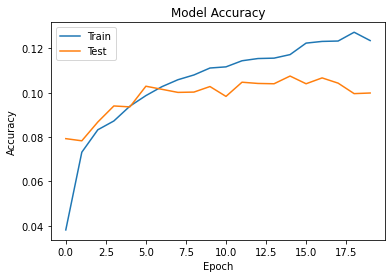

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left');

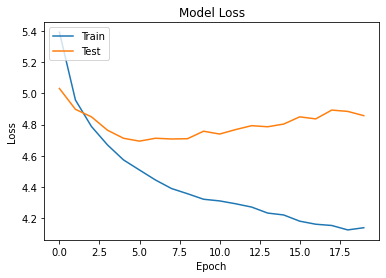

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left');

**Making Predictions for this, the Best Performing Model**

In [19]:
X_test[0:2]

array([[940, 616, 824, 748, 470, 951, 641, 817,  47,  91,  52, 345, 620,
        145, 916, 213, 611, 903, 883, 338],
       [840, 955, 177, 502, 911, 579, 502, 462, 278,  87, 617, 183, 631,
        451, 267, 357, 251, 483, 517, 345]])

In [20]:
preds = model.predict(X_test)
preds[0:2]

array([[7.8210789e-05, 9.3951535e-08, 4.2526885e-08, ..., 8.0722089e-08,
        3.8290520e-07, 2.9158308e-08],
       [3.3445630e-04, 1.1716454e-06, 1.2714277e-07, ..., 5.2623682e-07,
        1.0783189e-06, 8.3911786e-08]], dtype=float32)

In [21]:
#https://stackoverflow.com/questions/51382524/what-is-the-difference-between-predict-and-predict-class-functions-in-keras
#https://stackoverflow.com/questions/44806125/attributeerror-model-object-has-no-attribute-predict-classes

preds = np.argmax(preds, axis = 1)

In [22]:
df = pd.read_csv('../data/showsandsets.csv')

In [23]:
setlist = df['setlists'].tolist()
setlist = ''.join(setlist)
setlist = setlist.replace('][', ', ')
setlist = setlist.replace('[', '')
setlist = setlist.replace(']', '')
setlist = setlist.split(', ')
setlist[0:12]

["'Long Cool Woman in a Black Dress'",
 "'Proud Mary'",
 "'In the Midnight Hour'",
 "'Squeeze Box'",
 "'Roadhouse Blues'",
 "'Happy Birthday to You'",
 "'Scarlet Begonias'",
 "'Fire on the Mountain'",
 "'Makisupa Policeman'",
 "'In the Midnight Hour'",
 "'Wild Child'",
 "'Jam'"]

In [24]:
unique_songs = sorted(set(setlist))

In [25]:
from itertools import islice

rev_idx_list = {index: song for index, song in enumerate(unique_songs)}
#rev_idx_list #commented out for length

In [26]:
rev_idx_list[100]

"'A Wave of Hope'"

In [27]:
np.vectorize(rev_idx_list.get)(preds)[0]

"'Sleep Again'"

In [28]:
#https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key

np.vectorize(rev_idx_list.get)(preds)[500:520]

array(["'Rip This Joint'", "'Powderfinger'", "'Liquid Time'",
       "'Harry Hood'", "'Powderfinger'", "'Runaway Jim'",
       "'Family Picture'", "'Powderfinger'", "'Limb By Limb'",
       "'Hold to a Dream'", "'Bathtub Gin'", "'Bouncing Around the Room'",
       "'Hold to a Dream'", "'Weigh'",
       "'Stealing Time From the Faulty Plan'",
       "'Scents and Subtle Sounds'",
       "'McGrupp and the Watchful Hosemasters'", "New York'", "'Simple'",
       "'Bouncing Around the Room'"], dtype='<U38')

In [29]:
np.vectorize(rev_idx_list.get)(preds)[136:156]

array(["'Harry Hood'", "'Down with Disease'",
       "'You Gotta See Mama Every Night'", '"Mike\'s Song"',
       "'The Ocean'", "'The Maker'", "'Chalk Dust Torture'",
       "'Low Rider'", "'The Star Spangled Banner'",
       "'Also Sprach Zarathustra'", "'Samson Variation'", "'Fee'",
       "'Layla'", "'Down with Disease'", "'Chalk Dust Torture'",
       "'Sparks'", "'Character Zero'", "'Divided Sky'",
       "'Guelah Papyrus'", "'Chalk Dust Torture'"], dtype='<U38')

In [32]:
np.vectorize(rev_idx_list.get)(preds)[1117:1137]

array(["'AC/DC Bag'", "'Harry Hood'", "'Also Sprach Zarathustra'",
       "'Fee'", "'You Gotta See Mama Every Night'",
       "'Also Sprach Zarathustra'", "'Axilla (Part II)'", "'NICU'",
       "'Divided Sky'", "'Sing Monica'", "'Liquid Time'",
       "'Fly Famous Mockingbird'", "'Down with Disease'", 'None',
       "'The Ocean'", "'The Howling'", "'Character Zero'", "'Contact'",
       '"Cracklin\' Rosie"', "'Lonely Trip'"], dtype='<U38')

In [30]:
#Attempting to write a function to generate a setlist:

# def generate_full_setlist(model, n_songs):
    
#     setlist = []
    
#     for songs in range(1, n_songs):
#         preds = model.predict(X_rr)
        
#         # predict next song
#         for i in range(1, n_songs):
#             next_song = np.vectorize(rev_idx_list.get)(preds)[i]
        
#             # append to list
#             setlist.append(next_song)        
    
#     return setlist